# A/B-тесты. Задание 1

Добавляем то, что пригодится

In [1]:
import pandahouse
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Сформулируем запрос

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20220520'
}

q = 'SELECT \
    user_id, toDate(time) as day,\
    countIf(action=\'view\') as views, \
    countIf(action=\'like\') as likes, \
    likes / views as ctr, exp_group \
    FROM {db}.feed_actions \
    where (toDate(time) >= \'2022-04-17\' and \
    toDate(time) <= \'2022-04-23\' and \
    exp_group in (2, 3))\
    group by user_id, day, exp_group\
    order by day, user_id'

df = pandahouse.read_clickhouse(q, connection=connection)

Посмотрим, что получилось:

In [3]:
df.head()

,user_id,day,views,likes,ctr,exp_group
0,237,2022-04-17,32,2,0.062500,3
1,242,2022-04-17,18,4,0.222222,3
2,271,2022-04-17,33,4,0.121212,2
3,278,2022-04-17,8,3,0.375000,3
4,281,2022-04-17,58,12,0.206897,3


На всяки случай, взглянем на количество пользователей в каждой из выбранных групп: необходимо, чтобы разница была незначительной

In [4]:
df['exp_group'].value_counts()

3    17232
2    16905
Name: exp_group, dtype: int64

Зададим количество экспериментов и число пользователей в каждой подвыборке

In [5]:
N_EXP = 10000
n_count = 500

Пусть для каждой группы будет свой датафрейм

In [6]:
df_exp2 = df.loc[df['exp_group'] == 2]
df_exp3 = df.loc[df['exp_group'] == 3]

Запускаем t-тесты

In [7]:
t_p_values = np.zeros(N_EXP)
for _ in range(N_EXP):
    ctr_array2 = df_exp2.sample(n_count)['ctr']    
    ctr_array3 = df_exp3.sample(n_count)['ctr']
    t_p_values[_] = stats.ttest_ind(ctr_array2, ctr_array3, equal_var=False)[1]

Гистограмма полученных p значений

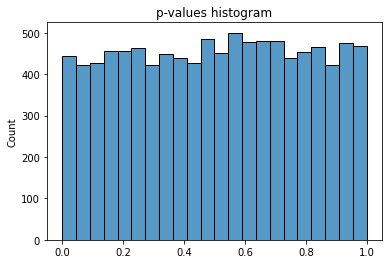

In [12]:
sns.histplot(t_p_values)
plt.title('p-values histogram')
plt.show()

Проверим, какой процент случаев дает статистически значимые различия:

In [13]:
invalid_p_rate = (np.sum([abs(t_p_values) <= 0.05]) / N_EXP) * 100
print(f'В {invalid_p_rate:.2f}% случаев p <= 0.05')

В 4.92% случаев p <= 0.05


Менее, чем в 5% случаев. На границе. 